In [1]:
from Bio import Phylo
from Bio import SeqIO
from augur.utils import json_to_tree
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import requests
import json
import math

In [2]:
from utils import sars2_genome_info, add_syn_mut_attribute, add_mut_accumulation_attr, add_del_accumulation_attr
from utils_plotting import get_color_palette, convert_linege_names, get_linear_reg_stats, DateToStr
from augur.utils import json_to_tree

In [3]:
#path to tree json
tree_file = '../auspice_033023/ncov_gisaid_adaptive-evolution-2023-03-30.json'

with open(tree_file, 'r') as f:
    tree_json = json.load(f)

#put tree in Bio.phylo format
tree = json_to_tree(tree_json)

In [4]:
# Display the first 2 elements of the dictionary
#for key in list(tree_json.keys())[:2]:
#    print(key, tree_json[key])

In [5]:
count = 0
for node in tree.find_clades(terminal = True): #terminal = True is only tips 
    #print(node.name)
    #print(node.branch_attrs["mutations"])
    #print(tree.get_path(node)) #list of nodes
    #print("\n") #adds space between each node
    count=count + 1
    if count >= 10:
        break

In [7]:
# creates a dictonary for each gene of interest and counts the number of mutations accumulated 
# throughout the path for each tree tip

genes_of_interest = ["ORF1a", "ORF1b", "S", "ORF3a", "E", "M", "ORF6", "ORF7a", "ORF7b", "ORF8", "N", "ORF9b"]

# create a dictionary for each gene of interest to store mutation counts for each tip
mutation_counts_by_gene = {}
for gene in genes_of_interest:
    mutation_counts_by_gene[gene] = {}

# loop through each tip and count mutations
for node in tree.find_clades(terminal=True): #loops through each terminal node in the tree
    path = tree.get_path(node) #gets path from the root of the tree to the current node
    path_mutations = [] #creates an empty list to store the mutations along path
    for i in range(len(path) - 1): #loops through each branch along the path, except for the last one (which leads to the current node)
        path_mutations += path[i].branch_attrs.get("mutations", []) #adds the mutations along the current branch to list
    for gene in genes_of_interest: #loops through each gene of interest
        gene_mutation_count = 0 #initializes a count of the mutations for the current gene to zero
        for mutation in path_mutations: # loops through each mutation along the path
            if mutation.split(":")[0] == gene: #checks if mutation is in current gene of interest
                gene_mutation_count += 1 #adds the mutation count +1 if mutation is in gene
        # store mutation count for tip in dictionary
        mutation_counts_by_gene[gene][node.name] = gene_mutation_count

# print mutation counts for each gene of interest
#for gene, counts in mutation_counts_by_gene.items():
#    print("Gene:", gene)
#    for tip, mutation_count in counts.items():
#        print("Tip:", tip, "Mutation count:", mutation_count)
        
#print mutation counts for the "S" gene
#print("Mutation counts for the S gene:")
#for tip, mutation_count in mutation_counts_by_gene["S"].items():
#    print("Tip:", tip, "Mutation count:", mutation_count)

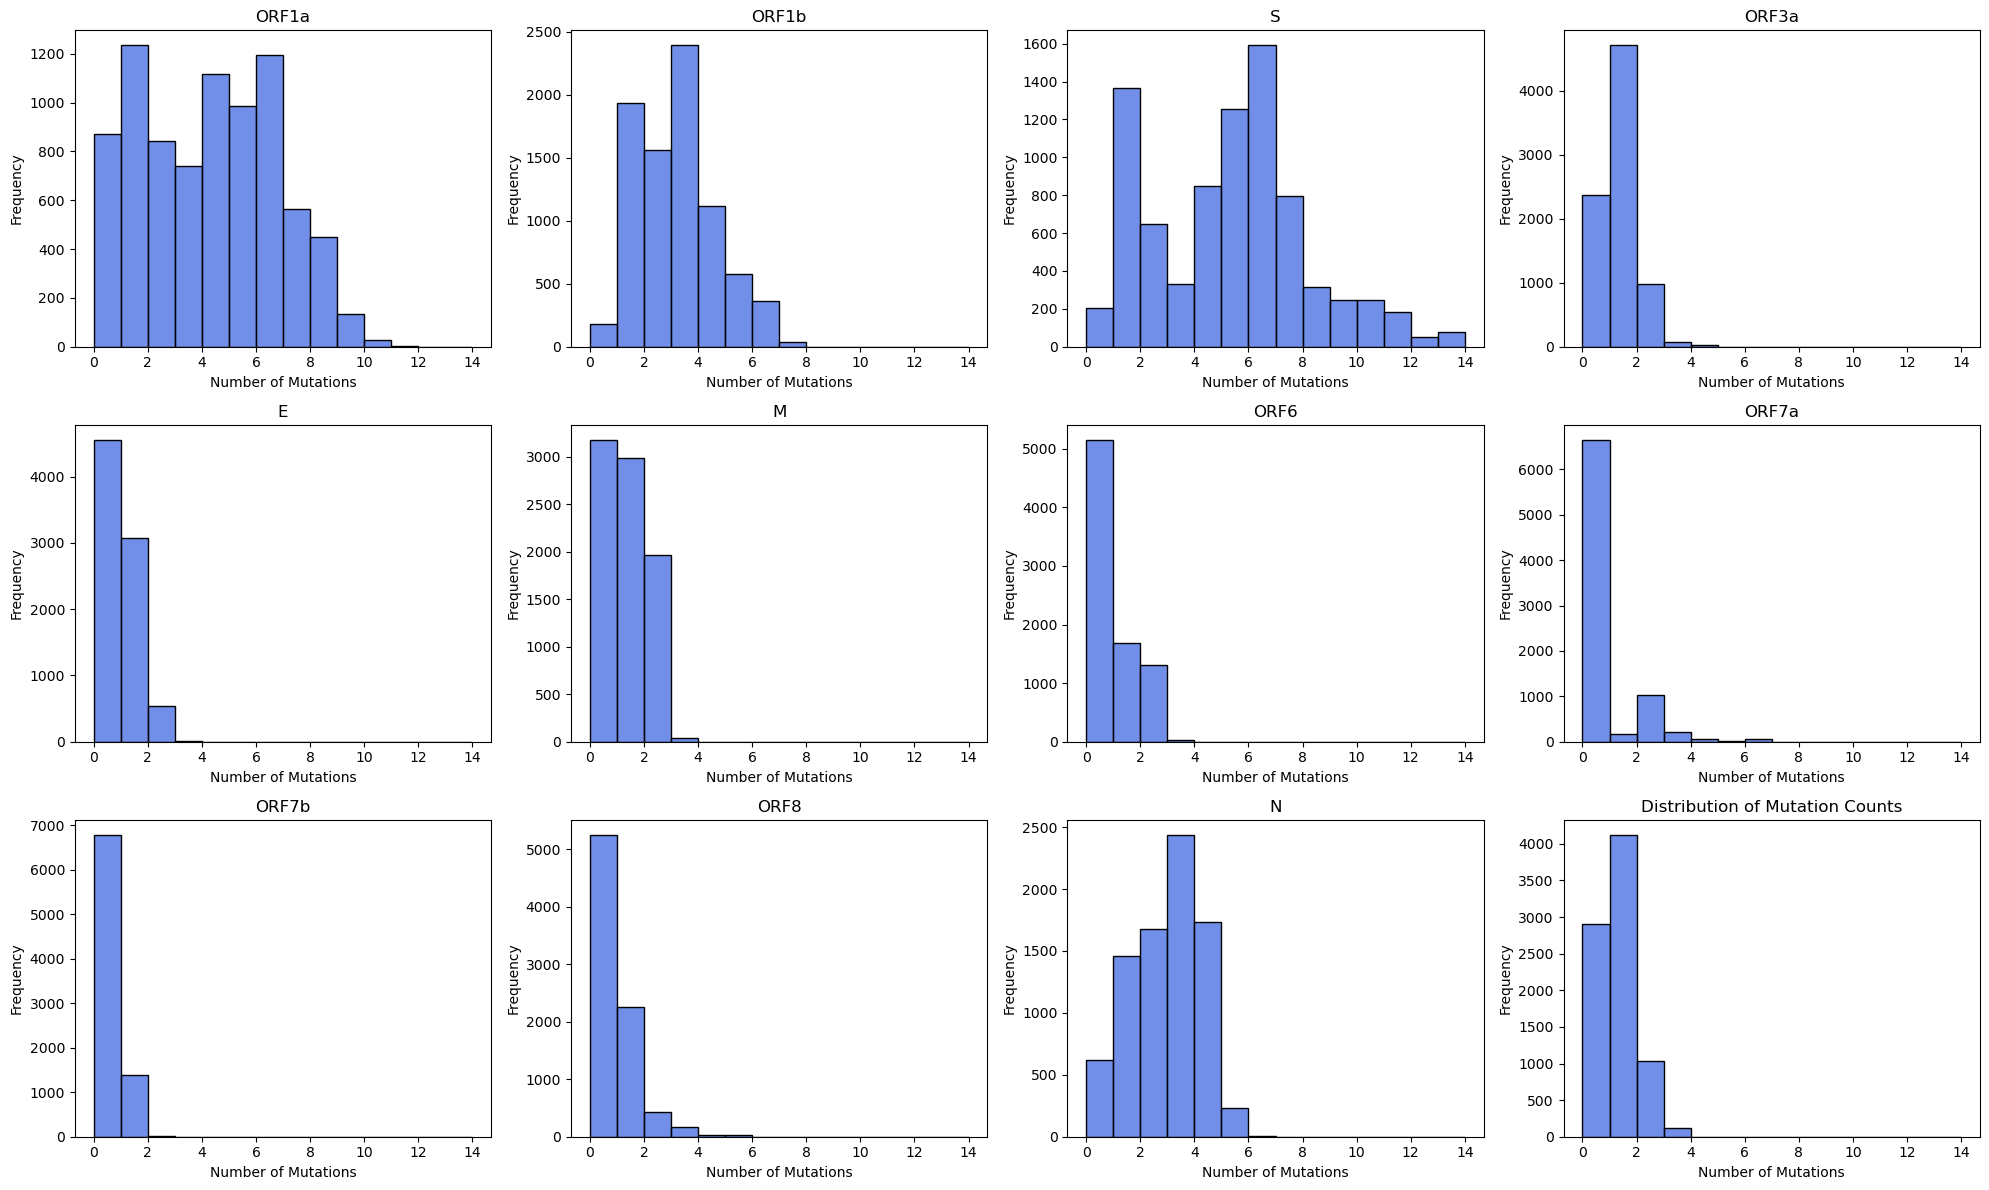

In [8]:
#To verify that the mutational accumulation count is correct, I graphed the frequency of the number of mutations.
#I expect S gene to have many high number of mutations and other genes to have a lower frequncey of high number of mutations. 

# create subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))
axes = axes.flatten()

# loop through each gene and plot the frequency of mutations
for i, gene in enumerate(genes_of_interest): #enumerate numbers each item in a list
    # get the mutation counts for the gene
    counts = list(mutation_counts_by_gene[gene].values())
    # plot histogram
    sns.histplot(ax=axes[i], data=counts, bins=range(15), color='royalblue')
    axes[i].set_title(gene)
    axes[i].set_xlabel("Number of Mutations")
    axes[i].set_ylabel("Frequency")

# adjust spacing and show plot
# set the title
plt.title("Distribution of Mutation Counts")
fig.tight_layout()
plt.show()

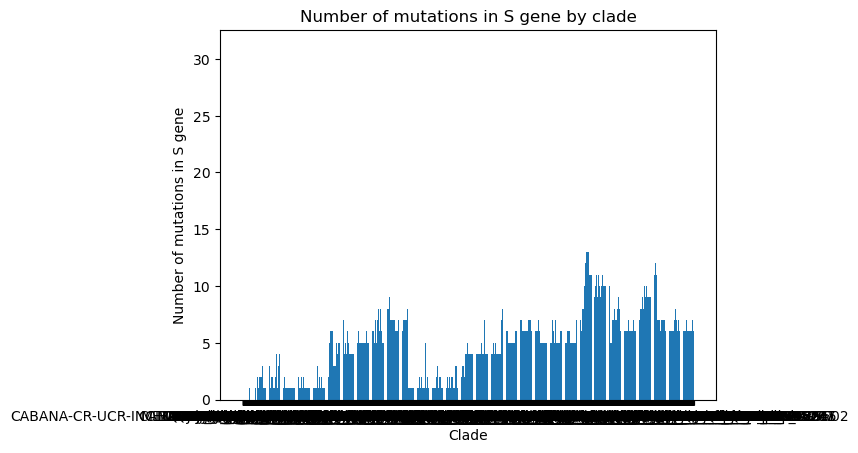

In [9]:
# Get a list of all the clades in the "S" gene
clades = [tip.split("/")[2] for tip in mutation_counts_by_gene["S"].keys()]
#clades = [tip.split("/")[2].split(" ")[-1][1:-1] for tip in mutation_counts_by_gene["S"].keys()]

# Get a list of the number of mutations for each tip in the "S" gene
mutation_counts = [mutation_counts_by_gene["S"][tip] for tip in mutation_counts_by_gene["S"].keys()]

# Create a dictionary to keep track of the total number of mutations for each clade
total_mutation_counts_by_clade = {}
for i in range(len(clades)):
    if clades[i] not in total_mutation_counts_by_clade:
        total_mutation_counts_by_clade[clades[i]] = 0
    total_mutation_counts_by_clade[clades[i]] += mutation_counts[i]

# Create a bar graph with the total number of mutations for each clade
plt.bar(total_mutation_counts_by_clade.keys(), total_mutation_counts_by_clade.values())
plt.xlabel("Clade")
plt.ylabel("Number of mutations in S gene")
plt.title("Number of mutations in S gene by clade")
plt.show()

# Ignore code below: Work in progress

In [10]:
reference_gene_locations, reference_gene_codon, gene_lengths_aa = sars2_genome_info()

In [11]:
tree = add_syn_mut_attribute(tree)

/Users/ariananagainis/miniconda3/lib/python3.10/site-packages/Bio/Seq.py:2954: BiopythonDeprecationWarning: myseq.toseq() is deprecated; please use Seq(myseq) instead.
  warnings.warn(


In [12]:
tree = add_mut_accumulation_attr(tree)

In [13]:
tree = add_del_accumulation_attr(tree)

In [14]:
regions_to_consider = [('S1', 's1_accumulation', 'S1', 'nonsyn'), ('S1_synonymous', 's1_syn_accumulation', 'S1', 'syn'), 
                       ('RdRp', 'rdrp_accumulation', 'RdRp', 'nonsyn'), ('N', 'n_accumulation', 'N', 'nonsyn'), 
                       ('E', 'e_accumulation', 'E', 'nonsyn'), ('M', 'm_accumulation', 'M', 'nonsyn'), 
                       ('Nsp6', 'nsp6_accumulation', 'Nsp6', 'nonsyn'), ('Nsp4', 'nsp4_accumulation', 'Nsp4', 'nonsyn'), 
                       ('S2', 's2_accumulation', 'S2', 'nonsyn'), ('ORF7a', 'orf7a_accumulation', 'ORF7a', 'nonsyn'), 
                       ('RdRp_synonymous', 'rdrp_syn_accumulation', 'RdRp', 'syn')]

In [15]:
# initialize list to store relevant information
muts_information = []


# only look at internal nodes
for node in tree.find_clades(terminal=False): # terminal = False (only internal), terminal = True (only tips), empty (all)

    logistic_growth = None
    if "logistic_growth" in node.node_attrs:
        logistic_growth = node.node_attrs["logistic_growth"]["value"]
    
    if hasattr(node, "node_attrs"):
        # get inferred node date
        date = node.node_attrs["num_date"]["value"]
        
        # get emerging lineage assignment of node 
        if 'emerging_lineage' in node.node_attrs:
            emerging_lineage = node.node_attrs['emerging_lineage']['value']
            emerging_lineage = convert_linege_names(emerging_lineage)
            
        # make tidy df for seaborn plotting
        for r in regions_to_consider:
            # there are no synonymous deletions, but S1 deletions will be stored with S1_syn mut information-> these will not be plotted
            # add figure_lineage key to group 
            muts_information.append({'clade': node.name, 'date': date,
                                     'emerging_lineage': emerging_lineage,
                                     'mut_location': r[0], 
                                     'num_muts': node.node_attrs[r[1]],  
                                     'muts_per_codon': node.node_attrs[r[1]]/gene_lengths_aa[r[2]],
                                     'num_deletions': node.node_attrs['deletion_accumulation'][r[2]], 
                                     'dels_per_codon': node.node_attrs['deletion_accumulation'][r[2]]/gene_lengths_aa[r[2]],
                                     'snps_per_codon': node.node_attrs['nonsyn_snps_accumulation'][r[2]]/gene_lengths_aa[r[2]],
                                     'logistic_growth': logistic_growth})


# make list into dataframe
muts_information_df = pd.DataFrame(muts_information)

In [16]:
print("emerging_lineage:", emerging_lineage)

emerging_lineage: 22B (Omicron)


In [17]:
# export R value for each gene
r_values_to_export = {'growth_rate_stats':[]}

for r in regions_to_consider:
    slope, r_value = get_linear_reg_stats(muts_information_df, r[0], 'logistic_growth', 'muts_per_codon')
    r_values_to_export['growth_rate_stats'].append({'data': 'observed', 'gene': r[2], 
                                                    'nonsyn_syn': r[3], 'r_value':r_value})

with open('randomization_results/growth_rate_stats/growth_stats_observed.json', 'w') as outfile:
    json.dump(r_values_to_export, outfile)

In [18]:
def plot_fig1ab(filename=None):
    
    #only color alpha, beta, delta, gamma, and group other vois
    # the basal lineage will be gray
    cmap = {'Alpha': "#5E1D9D", 'Beta':"#416CCE",'Delta':"#89BB6B",
            'Gamma':"#E14F2A", 'other VOI':"#DDAA3C",'basal': "#ABABAB"}

    # dictionary to convert labels to more readable labels
    readable_labels = {'nonsyn': 'Nonsynonymous', 'syn': 'Synonymous'}
    # whether or not to plot legend, based on subplot index
    plot_legend = {**{x:False for x in range(0,11)}, **{11:True}}
    
    # initialize figure format
    fig, axes= plt.subplots(3,4, figsize=(18,20), sharey=True)
    #fig, axes= plt.subplots(nrows=2, ncols=11, figsize=(18,20), sharey=True)
    plt.tight_layout()
    sns.set_style('white')
    
    for i, ax in enumerate(axes.flat):
        j = i % 4
        k = i // 4
        x_axis_variable = "date"
        x_label = "Date"
        # j indicies 3-5 will be reset to 0-2 so that the same mutations are plotted on ax1&ax4, ax2&ax5, ax3&ax6
        # and change x-axis to logistic growth rate
        if k >= 2:
            j = j + 8
            x_axis_variable = "logistic_growth"
            x_label = "Logistic Growth Rate"
        elif k >= 1:
            j = j + 4
        
        #print(j)
        #print(k)
        #print(i)
            
        ax = sns.scatterplot(x=x_axis_variable, y="muts_per_codon", hue_order= list(cmap.keys()), palette=cmap,
                      data = muts_information_df[muts_information_df['mut_location']==regions_to_consider[j][0]], 
                      ax=ax, legend=plot_legend[i])
        sns.regplot(x=x_axis_variable, y="muts_per_codon", scatter=False, ax=ax, 
                    data = muts_information_df[muts_information_df['mut_location']==regions_to_consider[j][0]], 
                    line_kws={"color":'black'}, ci=95)
        ax.set_xlabel(x_label, fontsize = 14)
        ax.set_title(f'{regions_to_consider[j][2]} {readable_labels[regions_to_consider[j][3]]}', 
                     fontsize = 16, fontweight='bold')
        
        # run linear regression on the plot
        slope, r_value = get_linear_reg_stats(muts_information_df, regions_to_consider[j][0], x_axis_variable, 'muts_per_codon')
        
        # label slope and r-value. 
        if k < 2:
            ax.annotate(f'{format(slope, "10.2E")} muts per codon per year \n $r$: {r_value}', 
                        xy=(2020.0,0.050), size=14, va='top', ha='left')
        # only label r-value
        elif k == 2:
            ax.annotate(f'$r$: {r_value}', xy=(-20,0.019), size=14, va='top', ha='left')
    
      # Add secondary axis showing absolute number of mutations for panel A subplots
    ax_1 = fig.axes[0].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S1'], 
                                                  lambda x: x / gene_lengths_aa['S1']))
    ax_2 = fig.axes[1].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S1'], 
                                                  lambda x: x / gene_lengths_aa['S1']))
    ax_3 = fig.axes[2].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['RdRp'], 
                                                  lambda x: x / gene_lengths_aa['RdRp']))
    ax_4 = fig.axes[4].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['N'], 
                                                  lambda x: x / gene_lengths_aa['N']))
    ax_5 = fig.axes[5].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['E'], 
                                                  lambda x: x / gene_lengths_aa['E']))
    #ax_6 = fig.axes[6].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['M'], 
                                                  #lambda x: x / gene_lengths_aa['M']))
    # force ticks to be integers, not decimals
    ax_3.set_yticks([0,2,4,6,8,10,12,14,16])
    for ax in [ax_1, ax_2, ax_3, ax_3, ax_4, ax_5]:
        ax.spines['right'].set_color('#888888')
        ax.tick_params(colors='#888888')

        
    # label y axis of the outer subplots
    for i, ax in enumerate(axes.flat):
        if i in [0,5]:
            ax.set_ylabel('Mutations per codon', fontsize = 14)
        if i == 2:
            ax_3.set_ylabel('Number of mutations', fontsize = 14, color='#ABABAB')
        # put emerging lineage legend on the bottom right plot
        if i == 5:
            handles, labels = ax.get_legend_handles_labels()
            lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.8, 0.9),
                            ncol=2, fontsize=13, title_fontsize='large',
                            title = r'$\bf{Lineage}$')
    
    # remove box around plot
    sns.despine(left=False, bottom=False)
    # adjust spacing between plots
    plt.subplots_adjust(hspace=1.0, wspace=0.5)
    
    # adjust fontsize and axis limits
    for i, ax in enumerate(axes.flat):
        if i<5:
            ax.set_ylim(-0.0025, 0.02)
            ax.set_xticks([p for p in ax.get_xticks()])
            ax.set_xlim(2019.9, 2023.38)
            ax.set_xticklabels([DateToStr(float(t)) for t in ax.get_xticks()], rotation=30)
            plt.setp(ax.get_xticklabels(), fontsize=10)
            plt.setp(ax.get_yticklabels(), fontsize=12)
        elif i>=5:
            ax.set_ylim(-0.0025,0.02)
            ax.set_xlim(-23, 13)
            plt.setp(ax.get_xticklabels(), fontsize=12)
            plt.setp(ax.get_yticklabels(), fontsize=12)
    
    # add figure labels
    plt.figtext(-0.05, 0.98, 'A', fontsize=24, fontweight='bold')
    plt.figtext(-0.05, 0.48, 'B', fontsize=24, fontweight='bold')
    

    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')

IndexError: list index out of range

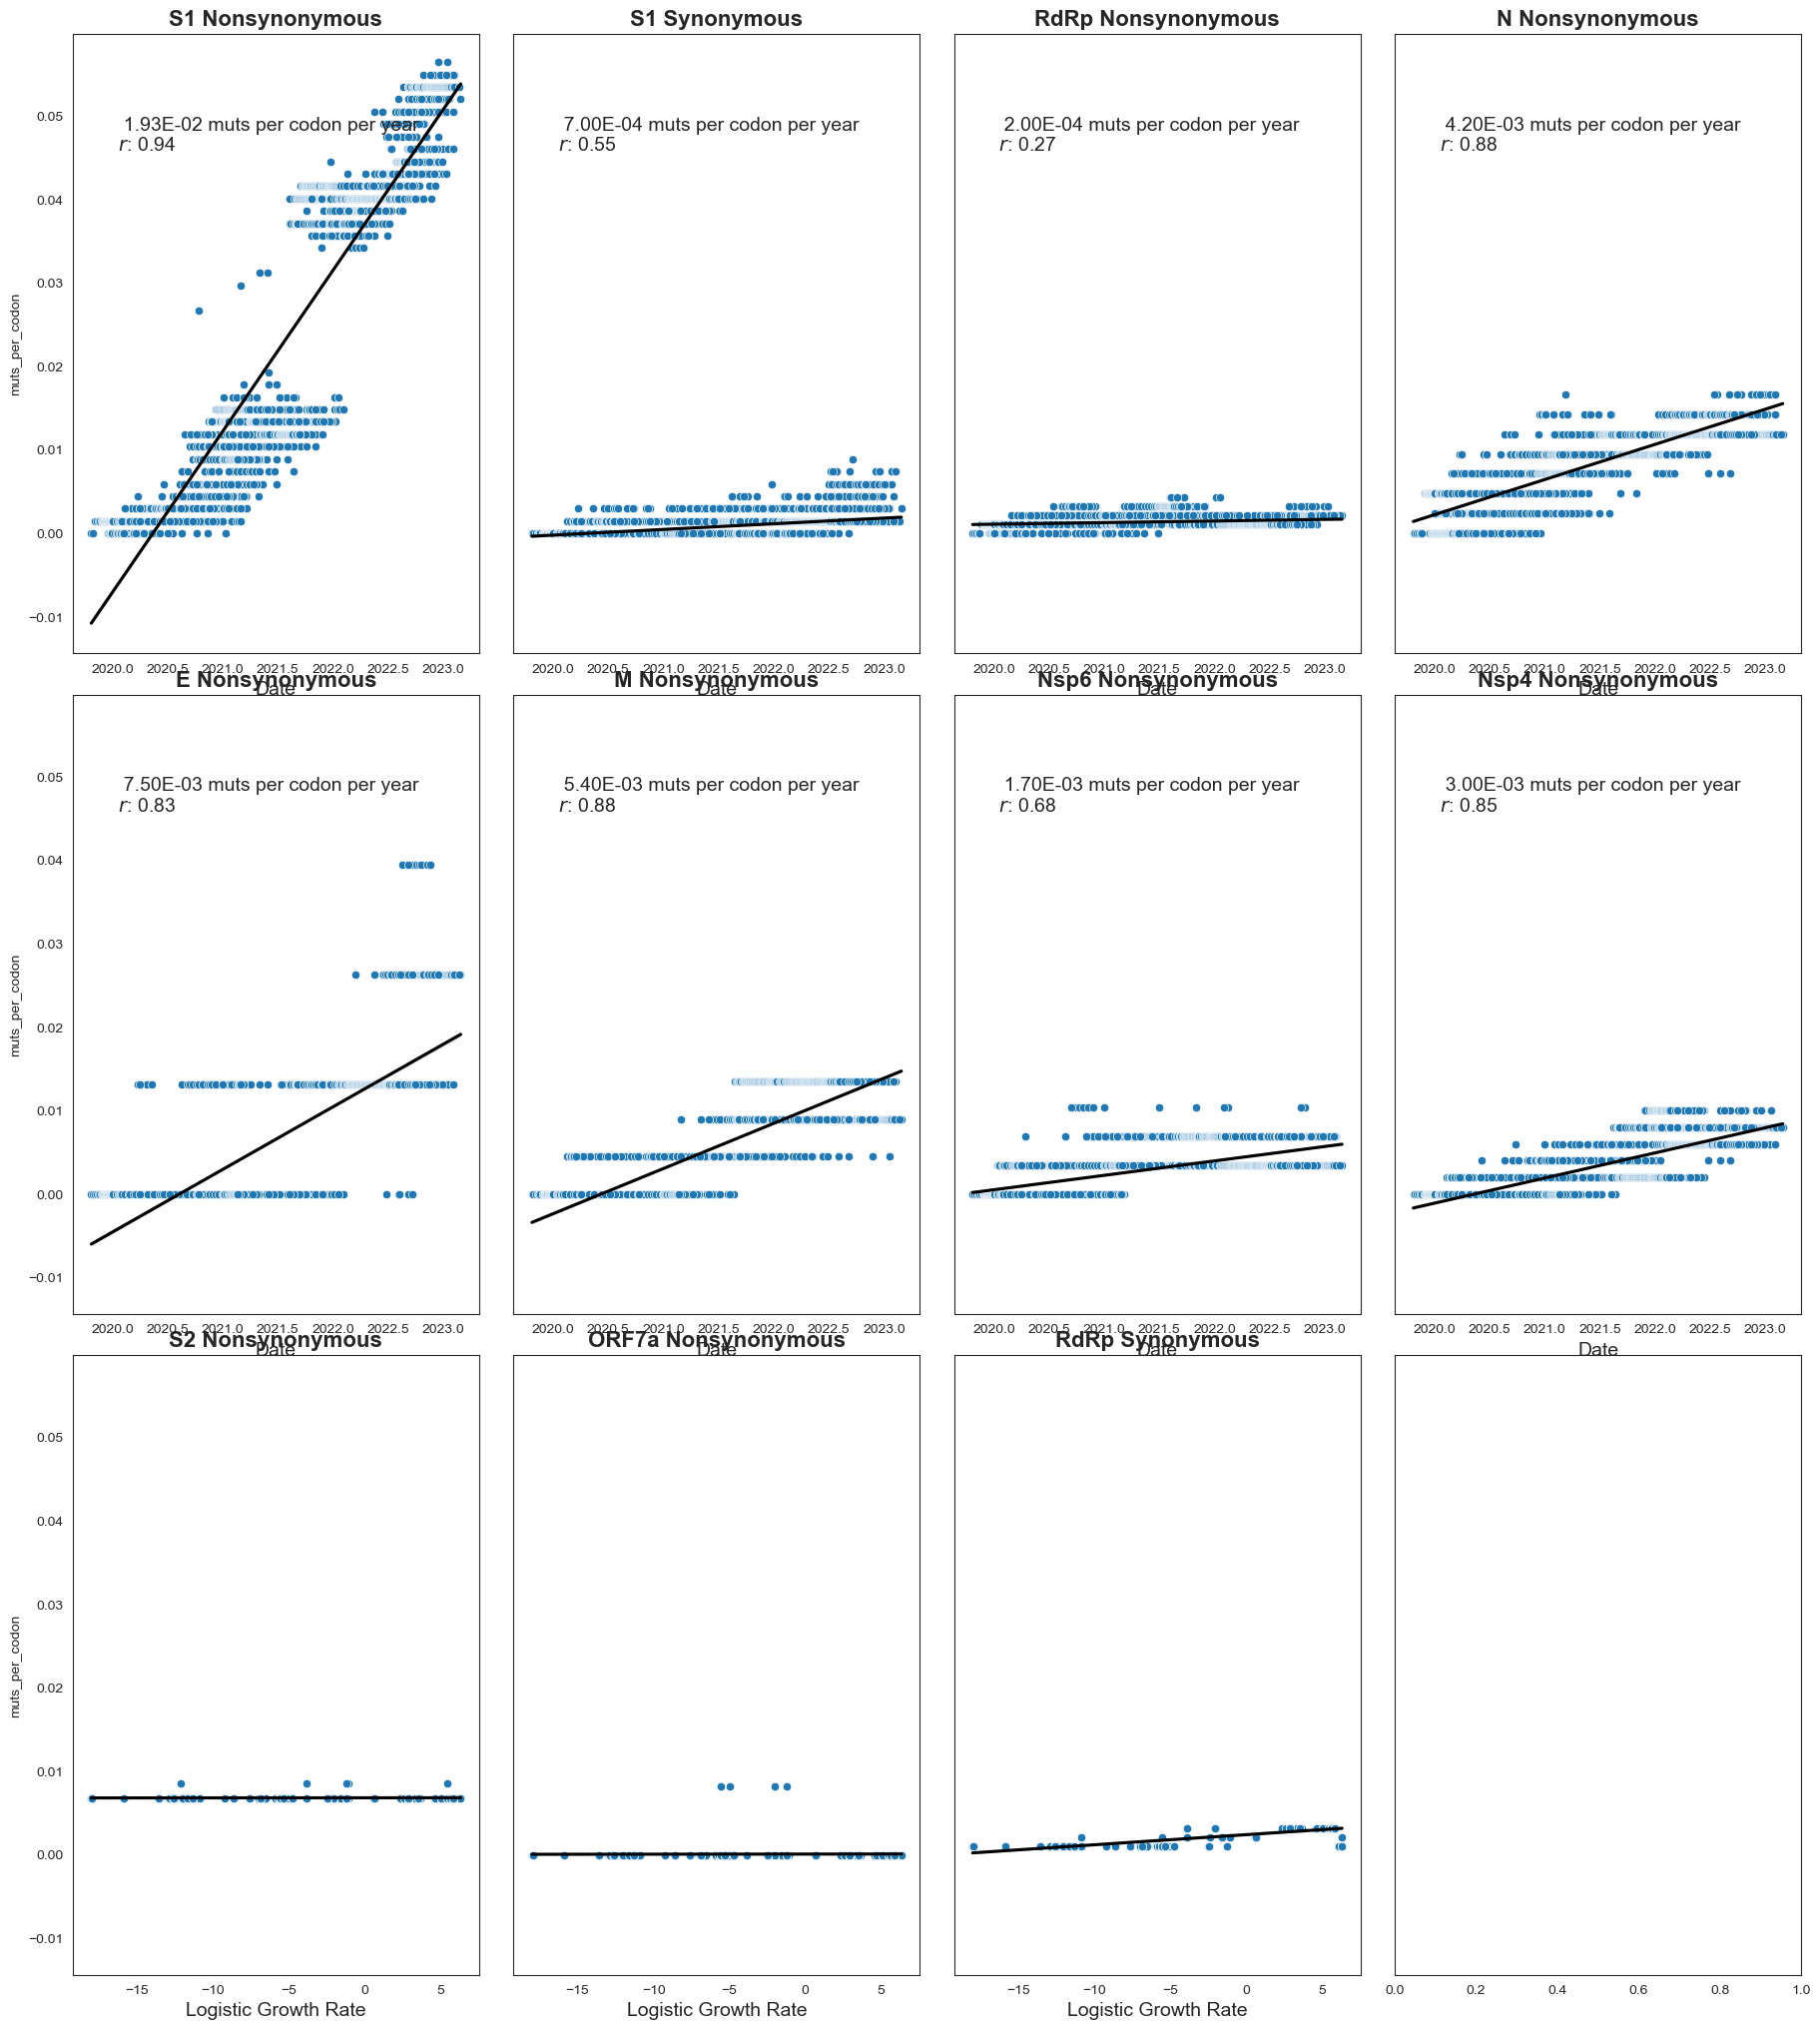

In [21]:
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default") #to reset warnings filter to default behavior
plot_fig1ab('plots/atte.png')

In [22]:
#just logistic growth plots - scales still need to be adjusted 
def plot_fig1ab(filename=None):
    
    #only color alpha, beta, delta, gamma, and group other vois
    # the basal lineage will be gray
    cmap = {'Alpha': "#5E1D9D", 'Beta':"#416CCE",'Delta':"#89BB6B",
            'Gamma':"#E14F2A", 'other VOI':"#DDAA3C",'basal': "#ABABAB"}

    # dictionary to convert labels to more readable labels
    readable_labels = {'nonsyn': 'Nonsynonymous', 'syn': 'Synonymous'}
    # whether or not to plot legend, based on subplot index
    plot_legend = {**{x:False for x in range(0,11)}, **{11:True}}
    
    # initialize figure format
    fig, axes= plt.subplots(4,3, figsize=(18,20), sharey=True)
    plt.tight_layout()
    sns.set_style('white')
    
    for i, ax in enumerate(axes.flat):
        j = i
        x_axis_variable = "date"
        x_label = "Date"
        # j indicies 3-5 will be reset to 0-2 so that the same mutations are plotted on ax1&ax4, ax2&ax5, ax3&ax6
        # and change x-axis to logistic growth rate
        if i>=j:
            #j = j-3
            x_axis_variable = "logistic_growth"
            x_label = "Logistic Growth Rate"
            
        #print(i)
        #print(j)
        ax = sns.scatterplot(x=x_axis_variable, y="muts_per_codon", hue_order= list(cmap.keys()), palette=cmap,
                      data = muts_information_df[muts_information_df['mut_location']==regions_to_consider[j][0]], 
                      ax=ax, legend=plot_legend[i])
        sns.regplot(x=x_axis_variable, y="muts_per_codon", scatter=False, ax=ax, 
                    data = muts_information_df[muts_information_df['mut_location']==regions_to_consider[j][0]], 
                    line_kws={"color":'black'}, ci=95)
        ax.set_xlabel(x_label, fontsize = 14)
        ax.set_title(f'{regions_to_consider[j][2]} {readable_labels[regions_to_consider[j][3]]}', 
                     fontsize = 16, fontweight='bold')
        # run linear regression on the plot
        slope, r_value = get_linear_reg_stats(muts_information_df, regions_to_consider[j][0], x_axis_variable, 'muts_per_codon')
        
        # label slope and r-value. 
        if i < 2:
            ax.annotate(f'{format(slope, "10.2E")} muts per codon per year \n $r$: {r_value}', 
                        xy=(2020.0,0.050), size=14, va='top', ha='left')
        # only label r-value
        elif i == 2:
            ax.annotate(f'$r$: {r_value}', xy=(-20,0.019), size=14, va='top', ha='left')

        
    # label y axis of the outer subplots
    for i, ax in enumerate(axes.flat):
        if i in [0,5]:
            ax.set_ylabel('Mutations per codon', fontsize = 14)
        if i == 2:
            ax_3.set_ylabel('Number of mutations', fontsize = 14, color='#ABABAB')
        # put emerging lineage legend on the bottom right plot
        if i == 5:
            handles, labels = ax.get_legend_handles_labels()
            lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.8, 0.9),
                            ncol=2, fontsize=13, title_fontsize='large',
                            title = r'$\bf{Lineage}$')
    
    # remove box around plot
    sns.despine(left=False, bottom=False)
    # adjust spacing between plots
    plt.subplots_adjust(hspace=1.0, wspace=0.5)
    
    # adjust fontsize and axis limits
    for i, ax in enumerate(axes.flat):
        if i<5:
            ax.set_ylim(-0.0025, 0.02)
            ax.set_xticks([p for p in ax.get_xticks()])
            ax.set_xlim(2019.9, 2023.38)
            ax.set_xticklabels([DateToStr(float(t)) for t in ax.get_xticks()], rotation=30)
            plt.setp(ax.get_xticklabels(), fontsize=10)
            plt.setp(ax.get_yticklabels(), fontsize=12)
        elif i>=5:
            ax.set_ylim(-0.0025,0.02)
            ax.set_xlim(-23, 13)
            plt.setp(ax.get_xticklabels(), fontsize=12)
            plt.setp(ax.get_yticklabels(), fontsize=12)
    

    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')

IndexError: list index out of range

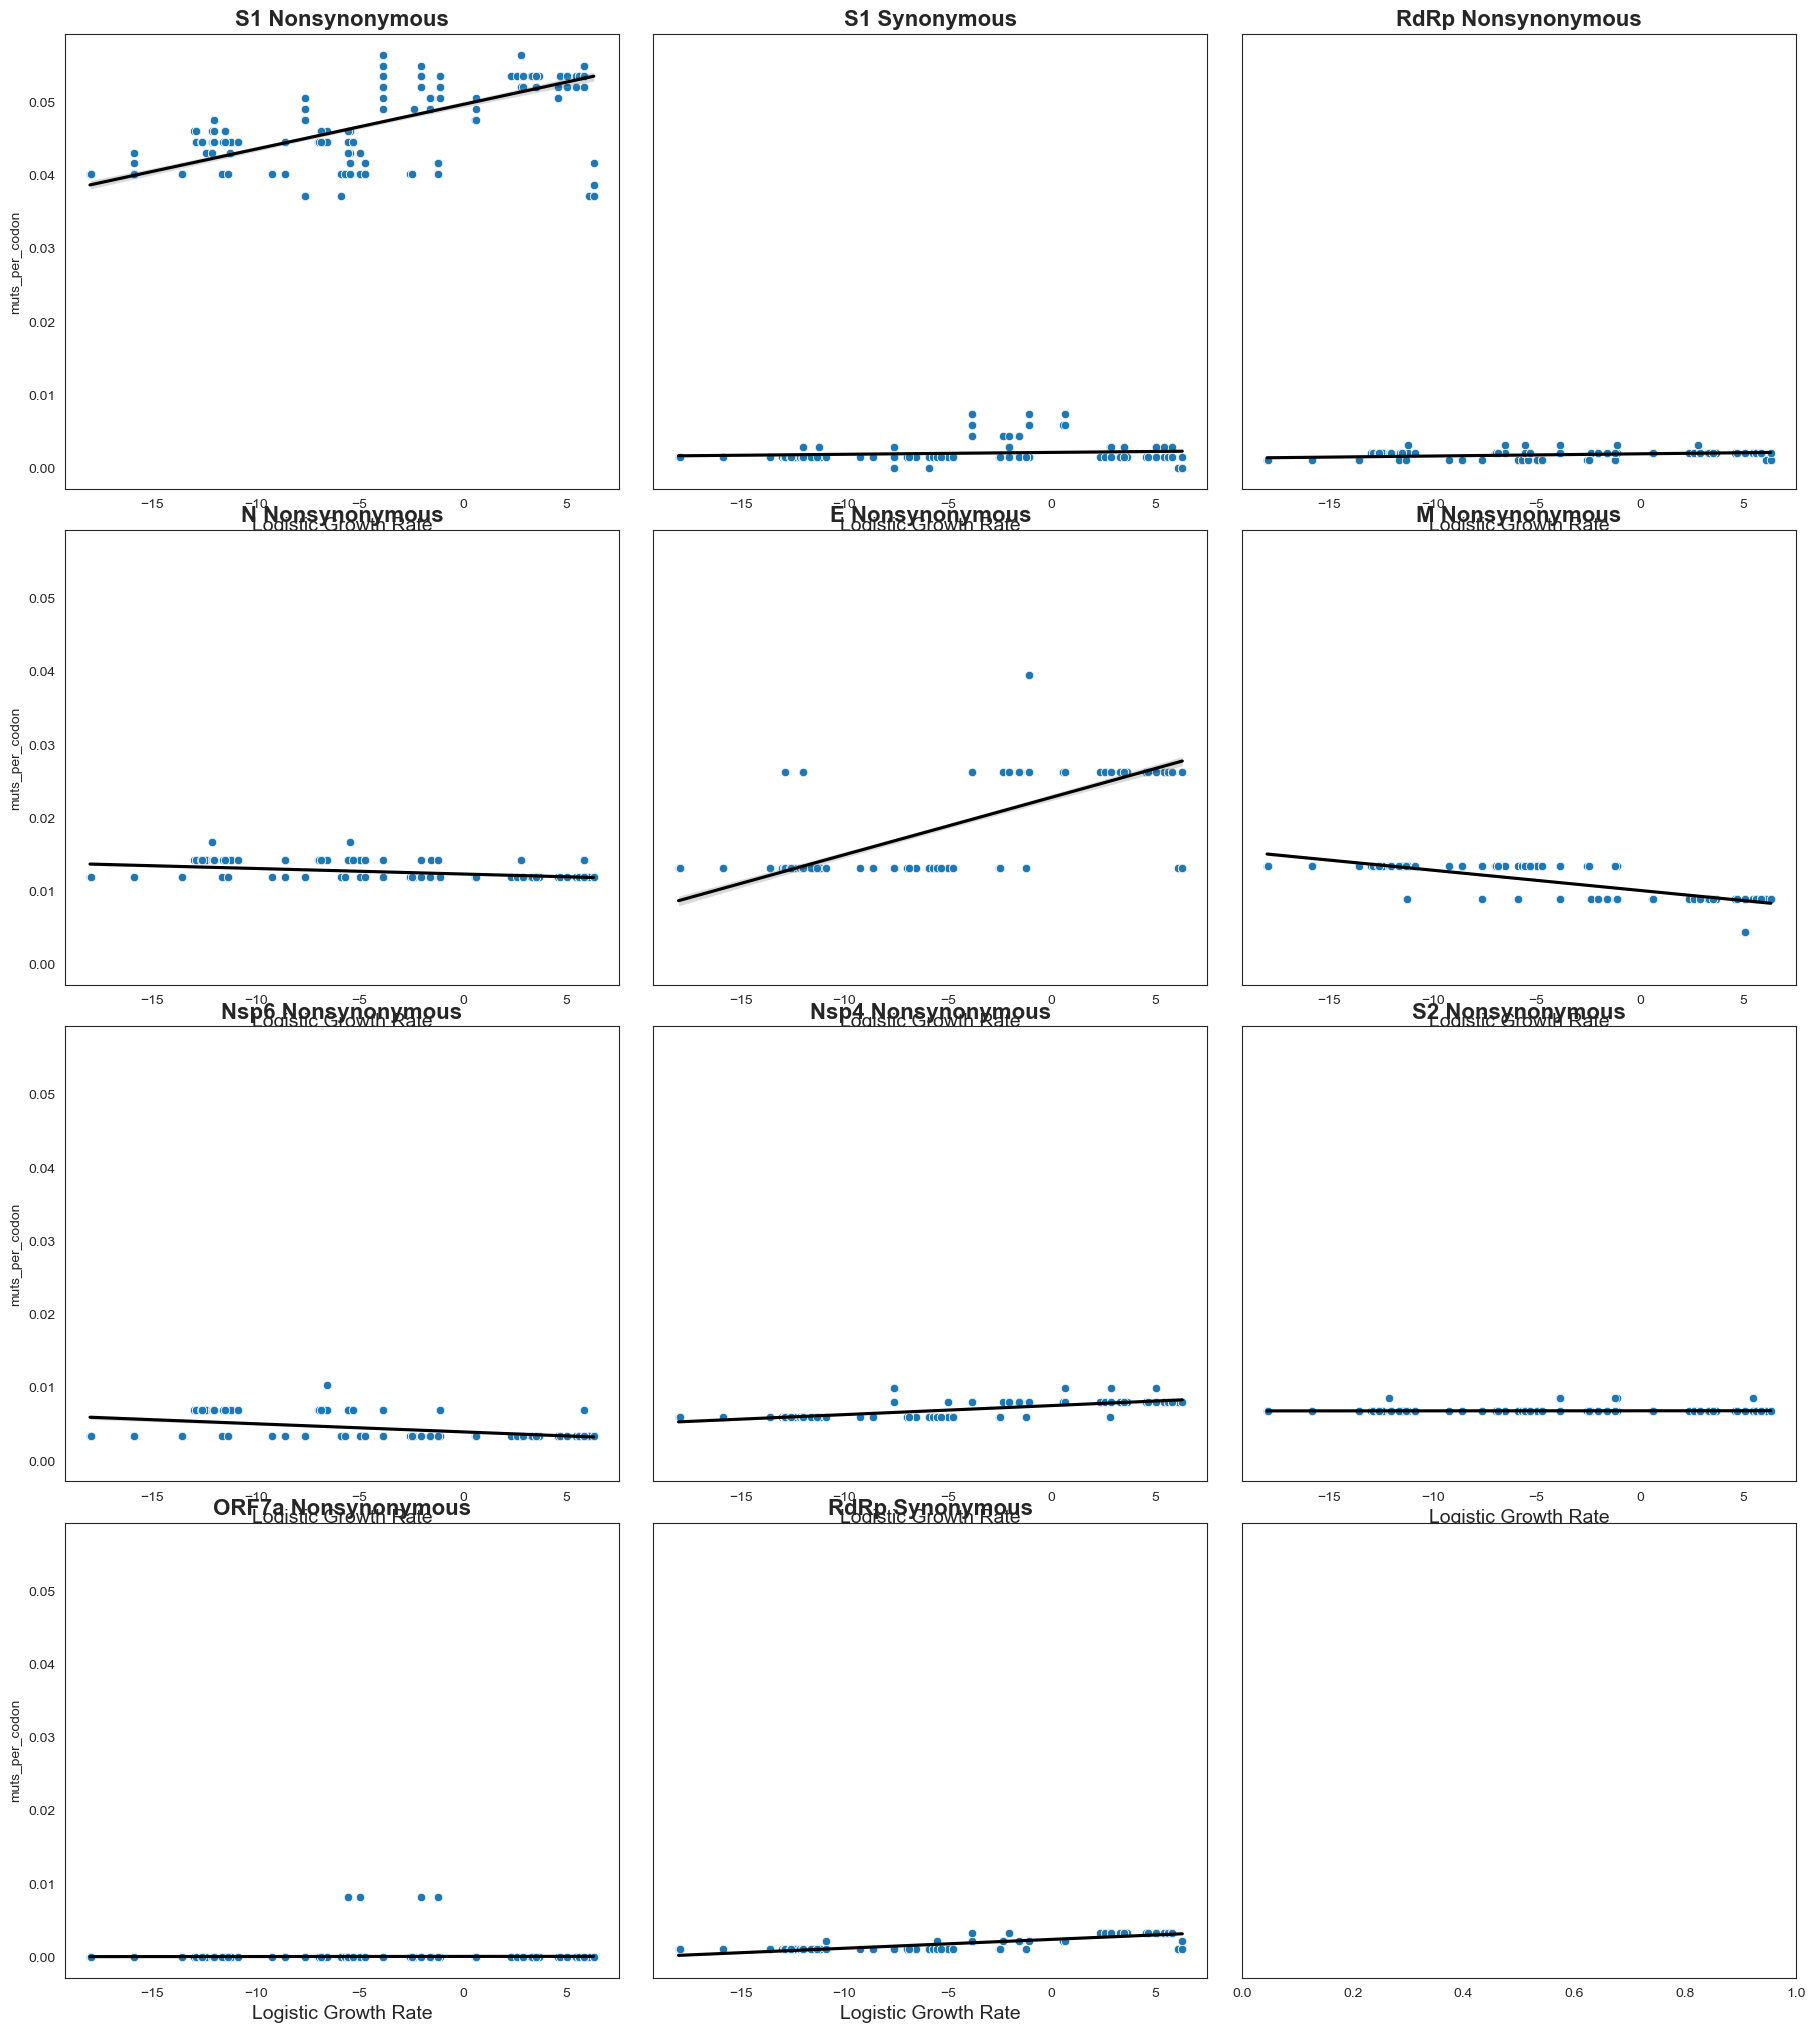

In [23]:
plot_fig1ab('plots/logistic_growth.png')